In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
np.random.seed(0)

In [3]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
errors = np.sqrt(np.abs(np.diagonal(syscov)))

### Generate a data set with covariance matrix from the original plus gaussian noise

In [4]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

In [5]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))


(1000, 31, 31)


In [6]:
from astroNN.nn.layers import MCDropout

In [7]:
# # This is the size of our encoded representations
# encoding_dim = 31  

# # This is our input image
# input_img2 = tf.keras.Input(shape=(31*31,))
# # begin encoder
# x2 = layers.Dense(100, activation='tanh')(input_img2)
# x2 = MCDropout(0.1)(x2)
# x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.1)(x2)
# encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
# x2 = MCDropout(0.1)(encoded2)
# #begin decoder
# x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.1)(x2)
# x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.1)(x2)
# decoded2 = layers.Dense(31*31, activation='linear')(x2)


# # This model maps an input to its reconstruction
# autoencoder2 = tf.keras.Model(input_img2, decoded2)
# autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
# autoencoder2.summary()

In [8]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [9]:
autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                    epochs=500,                                    
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test))
#                     callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 10ms/step - loss: 3.8278e-06 - val_loss: 1.4761e-06
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 2.0437e-06 - val_loss: 1.4082e-06
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8688e-06 - val_loss: 1.3290e-06
Epoch 4/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8385e-06 - val_loss: 1.3663e-06
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 1.8401e-06 - val_loss: 1.2854e-06
Epoch 6/500
25/25 [==============================] - 0s 4ms/step - loss: 1.7298e-06 - val_loss: 1.2915e-06
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 1.7228e-06 - val_loss: 1.2936e-06
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 1.7197e-06 - val_loss: 1.2748e-06
Epoch 9/500
25/25 [==============================] - 0s 4ms/step - loss: 1.6978e-06 - val_loss: 1.2702e-06
Epoch 10/500
25/25 [================

Epoch 77/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1349e-06 - val_loss: 1.0806e-06
Epoch 78/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1360e-06 - val_loss: 1.0823e-06
Epoch 79/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1357e-06 - val_loss: 1.0758e-06
Epoch 80/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1372e-06 - val_loss: 1.0776e-06
Epoch 81/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1379e-06 - val_loss: 1.0732e-06
Epoch 82/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1348e-06 - val_loss: 1.0866e-06
Epoch 83/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1345e-06 - val_loss: 1.0830e-06
Epoch 84/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1367e-06 - val_loss: 1.0912e-06
Epoch 85/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1326e-06 - val_loss: 1.0754e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 4ms/step - loss: 1.0996e-06 - val_loss: 1.0746e-06
Epoch 153/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1003e-06 - val_loss: 1.0771e-06
Epoch 154/500
25/25 [==============================] - 0s 3ms/step - loss: 1.1025e-06 - val_loss: 1.0743e-06
Epoch 155/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0965e-06 - val_loss: 1.0682e-06
Epoch 156/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0985e-06 - val_loss: 1.0791e-06
Epoch 157/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0997e-06 - val_loss: 1.0674e-06
Epoch 158/500
25/25 [==============================] - 0s 5ms/step - loss: 1.1015e-06 - val_loss: 1.0799e-06
Epoch 159/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0954e-06 - val_loss: 1.0699e-06
Epoch 160/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0955e-06 - val_loss: 1.0689e-06
Epoch 161/500
25/25 [============

25/25 [==============================] - 0s 4ms/step - loss: 1.0858e-06 - val_loss: 1.0655e-06
Epoch 228/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0831e-06 - val_loss: 1.0599e-06
Epoch 229/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0828e-06 - val_loss: 1.0692e-06
Epoch 230/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0816e-06 - val_loss: 1.0664e-06
Epoch 231/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0884e-06 - val_loss: 1.0705e-06
Epoch 232/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0849e-06 - val_loss: 1.0660e-06
Epoch 233/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0851e-06 - val_loss: 1.0647e-06
Epoch 234/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0879e-06 - val_loss: 1.0656e-06
Epoch 235/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0828e-06 - val_loss: 1.0684e-06
Epoch 236/500
25/25 [============

25/25 [==============================] - 0s 4ms/step - loss: 1.0762e-06 - val_loss: 1.0633e-06
Epoch 303/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0816e-06 - val_loss: 1.0699e-06
Epoch 304/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0785e-06 - val_loss: 1.0661e-06
Epoch 305/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0804e-06 - val_loss: 1.0667e-06
Epoch 306/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0753e-06 - val_loss: 1.0640e-06
Epoch 307/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0746e-06 - val_loss: 1.0603e-06
Epoch 308/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0775e-06 - val_loss: 1.0681e-06
Epoch 309/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0809e-06 - val_loss: 1.0683e-06
Epoch 310/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0774e-06 - val_loss: 1.0628e-06
Epoch 311/500
25/25 [============

25/25 [==============================] - 0s 4ms/step - loss: 1.0708e-06 - val_loss: 1.0588e-06
Epoch 378/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0763e-06 - val_loss: 1.0694e-06
Epoch 379/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0772e-06 - val_loss: 1.0594e-06
Epoch 380/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0738e-06 - val_loss: 1.0609e-06
Epoch 381/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0738e-06 - val_loss: 1.0641e-06
Epoch 382/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0743e-06 - val_loss: 1.0621e-06
Epoch 383/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0739e-06 - val_loss: 1.0718e-06
Epoch 384/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0801e-06 - val_loss: 1.0616e-06
Epoch 385/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0768e-06 - val_loss: 1.0656e-06
Epoch 386/500
25/25 [============

25/25 [==============================] - 0s 4ms/step - loss: 1.0692e-06 - val_loss: 1.0620e-06
Epoch 453/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0681e-06 - val_loss: 1.0630e-06
Epoch 454/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0726e-06 - val_loss: 1.0603e-06
Epoch 455/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0715e-06 - val_loss: 1.0636e-06
Epoch 456/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0740e-06 - val_loss: 1.0631e-06
Epoch 457/500
25/25 [==============================] - 0s 5ms/step - loss: 1.0723e-06 - val_loss: 1.0629e-06
Epoch 458/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0715e-06 - val_loss: 1.0718e-06
Epoch 459/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0720e-06 - val_loss: 1.0680e-06
Epoch 460/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0712e-06 - val_loss: 1.0604e-06
Epoch 461/500
25/25 [============

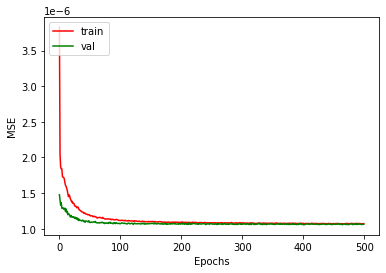

In [10]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [11]:
# encoder2 = tf.keras.Model(input_img2, encoded2)
# # This is our encoded (32-dimensional) input
# encoded2_input = tf.keras.Input(shape=(encoding_dim,))

# decoder2_layer1 = autoencoder2.layers[-5]
# decoder2_layer2 = autoencoder2.layers[-4]
# decoder2_layer3 = autoencoder2.layers[-3]
# decoder2_layer4 = autoencoder2.layers[-2]
# decoder2_layer5 = autoencoder2.layers[-1]

# # create the decoder model
# decoder2 = Model(encoded2_input, 
#                 decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [12]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [13]:
decoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
________________________________________________

In [14]:
# encoded_imgs = encoder2.predict(covset_test)
# decoded_imgs = decoder2.predict(encoded_imgs)
# print(np.shape(encoded_imgs))
# df = pd.DataFrame(encoded_imgs)


(200, 31)


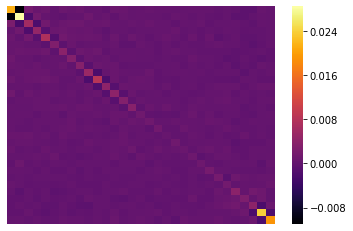

In [15]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")

In [16]:
fake_encoded = np.zeros((1, 31))
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)

(1, 31)


In [17]:
# # Generate test data
# test_batch_size = 31*31
# # x_test = np.random.uniform(0, np.max(z), test_batch_size)
# # x_test = np.linspace(0, 2., test_batch_size)
# mc_dropout_num = 100  # Run Dropout 100 times
# predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
# uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
# for i in range(mc_dropout_num):
#     predictions_dec[i] = decoder2.predict(fake_encoded)
    
# # get mean results and its varience
# prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
# std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
# np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

In [18]:
# sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', 
#             robust=False)

# FFNN

In [19]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

z = data[:,0]
dl = data[:,1:]
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)



In [20]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
#     x = MCDropout(0.02)(efirst)
    x = Dense(50, activation='relu')(efirst)
    x = MCDropout(0.02)(x)
    x = Dense(50, activation='relu')(x)
#     x = MCDropout(0.02)(x)
    x = Dense(30, activation='relu')(x)
#     x = MCDropout(0.02)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [21]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=1,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/1000
24/24 [==============================] - 0s 7ms/step - loss: 1433.3583 - val_loss: 1721.4685
Epoch 2/1000
24/24 [==============================] - 0s 2ms/step - loss: 1373.7225 - val_loss: 1634.3652
Epoch 3/1000
24/24 [==============================] - 0s 2ms/step - loss: 1129.4508 - val_loss: 1288.0494
Epoch 4/1000
24/24 [==============================] - 0s 2ms/step - loss: 464.7750 - val_loss: 472.8306
Epoch 5/1000
24/24 [==============================] - 0s 2ms/step - loss: 139.8941 - val_loss: 248.2274
Epoch 6/1000
24/24 [==============================] - 0s 2ms/step - loss: 93.8954 - val_loss: 228.3619
Epoch 7/1000
24/24 [==============================] - 0s 2ms/step - loss: 80.2901 - val_loss: 145.2112
Epoch 8/1000
24/24 [==============================] - 0s 2ms/step - loss: 83.1069 - val_loss: 159.3521
Epoch 9/1000
24/24 [==============================] - 0s 2ms/step - loss: 78.3462 - val_loss: 143.6254
Epoch 10/1000
24/24 [==============================] - 0s 2ms/

24/24 [==============================] - 0s 2ms/step - loss: 3.8121 - val_loss: 2.6239
Epoch 82/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.3247 - val_loss: 0.9876
Epoch 83/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.4285 - val_loss: 2.8569
Epoch 84/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.6570 - val_loss: 0.2056
Epoch 85/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.5013 - val_loss: 1.0693
Epoch 86/1000
24/24 [==============================] - 0s 2ms/step - loss: 3.4657 - val_loss: 1.2929
Epoch 87/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.3119 - val_loss: 3.7613
Epoch 88/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.1815 - val_loss: 0.9798
Epoch 89/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.7376 - val_loss: 4.1730
Epoch 90/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.3015 - val_loss: 5.4488
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 1.2469 - val_loss: 0.4724
Epoch 162/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.9611 - val_loss: 0.1318
Epoch 163/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.3305 - val_loss: 1.2218
Epoch 164/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.0816 - val_loss: 3.0924
Epoch 165/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.6768 - val_loss: 1.2028
Epoch 166/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.9764 - val_loss: 5.2196
Epoch 167/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.0496 - val_loss: 2.0981
Epoch 168/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.5888 - val_loss: 4.0245
Epoch 169/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.9412 - val_loss: 8.0035
Epoch 170/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.9489 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 0.8811 - val_loss: 0.6703
Epoch 242/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.4109 - val_loss: 3.0053
Epoch 243/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.4549 - val_loss: 1.0259
Epoch 244/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.1729 - val_loss: 0.6766
Epoch 245/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.1341 - val_loss: 0.7708
Epoch 246/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.1547 - val_loss: 2.2722
Epoch 247/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.4528 - val_loss: 0.6526
Epoch 248/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.3490 - val_loss: 1.4542
Epoch 249/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.4826 - val_loss: 2.4497
Epoch 250/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.2183 - val_loss: 1.

24/24 [==============================] - 0s 2ms/step - loss: 1.5262 - val_loss: 1.1347
Epoch 322/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.7170 - val_loss: 1.5450
Epoch 323/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.2900 - val_loss: 2.4617
Epoch 324/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.4540 - val_loss: 8.0345
Epoch 325/1000
24/24 [==============================] - 0s 2ms/step - loss: 3.5846 - val_loss: 1.3238
Epoch 326/1000
24/24 [==============================] - 0s 2ms/step - loss: 2.4595 - val_loss: 1.9076
Epoch 327/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.6072 - val_loss: 0.3037
Epoch 328/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.8439 - val_loss: 1.9302
Epoch 329/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.1411 - val_loss: 0.5899
Epoch 330/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.3996 - val_loss: 2.

24/24 [==============================] - 0s 2ms/step - loss: 0.8942 - val_loss: 1.5337
Epoch 402/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.4929 - val_loss: 3.6700
Epoch 403/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.3233 - val_loss: 0.3537
Epoch 404/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.0732 - val_loss: 0.5206
Epoch 405/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.6896 - val_loss: 1.2861
Epoch 406/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5709 - val_loss: 1.4067
Epoch 407/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.6789 - val_loss: 2.1894
Epoch 408/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.5600 - val_loss: 1.3598
Epoch 409/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.7760 - val_loss: 1.0889
Epoch 410/1000
24/24 [==============================] - 0s 3ms/step - loss: 2.0862 - val_loss: 3.

24/24 [==============================] - 0s 3ms/step - loss: 1.1500 - val_loss: 2.0971
Epoch 482/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.0373 - val_loss: 3.2147
Epoch 483/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.1570 - val_loss: 1.1566
Epoch 484/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.2685 - val_loss: 1.8197
Epoch 485/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.0599 - val_loss: 0.3397
Epoch 486/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.7605 - val_loss: 2.2081
Epoch 487/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.3306 - val_loss: 0.2999
Epoch 488/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.3868 - val_loss: 0.6557
Epoch 489/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.8546 - val_loss: 3.7384
Epoch 490/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.8568 - val_loss: 0.

24/24 [==============================] - 0s 3ms/step - loss: 0.5882 - val_loss: 0.7296
Epoch 562/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.6015 - val_loss: 1.5122
Epoch 563/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.7136 - val_loss: 0.2480
Epoch 564/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.7668 - val_loss: 1.1108
Epoch 565/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.4726 - val_loss: 0.3318
Epoch 566/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.6243 - val_loss: 0.6036
Epoch 567/1000
24/24 [==============================] - 0s 4ms/step - loss: 1.1285 - val_loss: 0.2321
Epoch 568/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.3821 - val_loss: 0.4455
Epoch 569/1000
24/24 [==============================] - 0s 4ms/step - loss: 1.0104 - val_loss: 0.4717
Epoch 570/1000
24/24 [==============================] - 0s 4ms/step - loss: 2.6955 - val_loss: 1.

24/24 [==============================] - 0s 2ms/step - loss: 0.6599 - val_loss: 0.4660
Epoch 642/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.6343 - val_loss: 0.5273
Epoch 643/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.7407 - val_loss: 4.4373
Epoch 644/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.0657 - val_loss: 1.2192
Epoch 645/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.8449 - val_loss: 0.3793
Epoch 646/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.7303 - val_loss: 0.2452
Epoch 647/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.3675 - val_loss: 0.7637
Epoch 648/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4905 - val_loss: 0.5930
Epoch 649/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.9192 - val_loss: 1.7046
Epoch 650/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5214 - val_loss: 0.

24/24 [==============================] - 0s 4ms/step - loss: 0.3218 - val_loss: 0.1287
Epoch 722/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.2457 - val_loss: 0.4709
Epoch 723/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.7605 - val_loss: 0.6934
Epoch 724/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.5710 - val_loss: 3.6149
Epoch 725/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.4686 - val_loss: 0.9856
Epoch 726/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.7837 - val_loss: 4.6186
Epoch 727/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5216 - val_loss: 0.2467
Epoch 728/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.6003 - val_loss: 1.6765
Epoch 729/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.9822 - val_loss: 0.3972
Epoch 730/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.3341 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 1.0497 - val_loss: 0.3143
Epoch 802/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4596 - val_loss: 0.2063
Epoch 803/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4075 - val_loss: 0.1599
Epoch 804/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5252 - val_loss: 0.3189
Epoch 805/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.6661 - val_loss: 0.2741
Epoch 806/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.3198 - val_loss: 0.4966
Epoch 807/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.6778 - val_loss: 1.0412
Epoch 808/1000
24/24 [==============================] - 0s 3ms/step - loss: 1.0509 - val_loss: 0.6745
Epoch 809/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5533 - val_loss: 0.5339
Epoch 810/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.8052 - val_loss: 1.

24/24 [==============================] - 0s 3ms/step - loss: 0.8185 - val_loss: 0.7787
Epoch 882/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.5417 - val_loss: 0.2350
Epoch 883/1000
24/24 [==============================] - 0s 2ms/step - loss: 1.1785 - val_loss: 0.5056
Epoch 884/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.7075 - val_loss: 1.3236
Epoch 885/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2474 - val_loss: 0.0743
Epoch 886/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4109 - val_loss: 0.3268
Epoch 887/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.1575 - val_loss: 0.6858
Epoch 888/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.3499 - val_loss: 0.2592
Epoch 889/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.5895 - val_loss: 0.1214
Epoch 890/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.3597 - val_loss: 1.

24/24 [==============================] - 0s 2ms/step - loss: 0.4973 - val_loss: 0.5994
Epoch 962/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4789 - val_loss: 0.6758
Epoch 963/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5770 - val_loss: 0.3705
Epoch 964/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.5765 - val_loss: 0.5440
Epoch 965/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4697 - val_loss: 0.1568
Epoch 966/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.2624 - val_loss: 0.4118
Epoch 967/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.4292 - val_loss: 0.3587
Epoch 968/1000
24/24 [==============================] - 0s 2ms/step - loss: 0.3930 - val_loss: 0.6346
Epoch 969/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.6218 - val_loss: 0.2866
Epoch 970/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.8099 - val_loss: 1.

In [22]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)



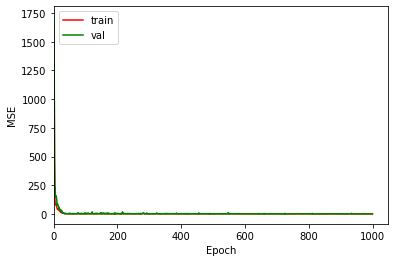

In [23]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('loss_dropoutJLA.png', dpi=100)

In [24]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(0.01, 1.3, 31)

ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model2.predict(ranzz)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$

(31,)
(200, 31)
<class 'numpy.ndarray'>


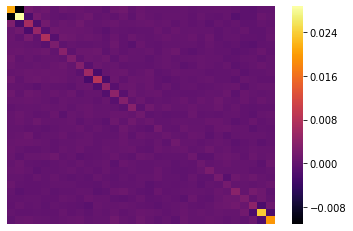

In [37]:
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]
decoded_fake = decoder.predict(fake_encoded)
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))

np.savetxt("fake_binned_JLA_COVdecodedDO2.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
sns.heatmap(pd.DataFrame(decoded_fake.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [26]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [27]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

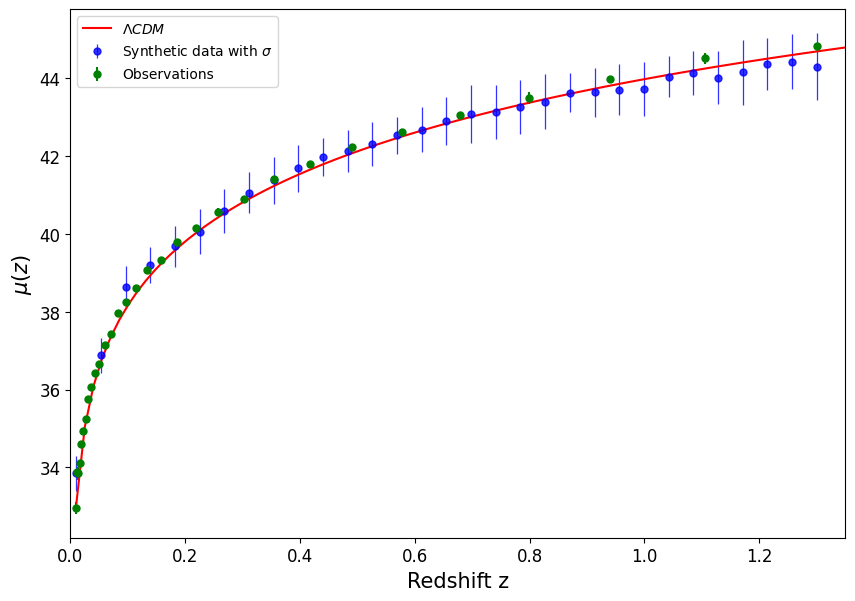

In [28]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

# fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))


# std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))
# std_dropout_diag = np.diagonal(std_mc_dropout_dec.reshape(31,31))

# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 + std_dropout_diag)
# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 **2 + std_dropout_diag)

sigma = np.sqrt(fakeerrors **2 + std_mc_dropout.reshape(31,))

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift z', fontsize=15)
plt.ylabel('$\mu(z)$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=80)

In [29]:
# matrix_with_all_err = prediction_mc_dropout_dec[0, :].reshape(31,31)
# np.fill_diagonal(matrix_with_all_err, sigma**2)

In [38]:
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [35]:
autoencoder.save('autoencoderJLA_DO.h5')
decoder.save('decoderJLA_DO.h5')
neural_model2.save('FFNN_JLA_DO.h5')
encoder.save('encoderJLA_DO.h5')